# 工作流程
* 載入需要的套件
* 從COCO的驗證資料集中找一張範例照片，並且網上下載，顯示照片
* 進行物件偵測，做方框標記
* 列出偵測出來的類別代碼，以及方框座標
* 列出代碼對應的物件
* 顯示辨識出來的圖形
* 展示骨骼標記
* 展示全景分割

In [1]:
!nvidia-smi

Tue Nov  3 02:33:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install dependencies: 
# COCO資料集的資料標籤方式，採用yaml格式，
# pyyaml套件讀取資料
# pycocotools為python針對COCO資料集操作所提供之api tools
# 安裝pytorch PyTorch是一個開源機器學習框架
# torch瀏覽器
# torchvision 內含有(流行的數據集、模型架構、用於計算機視覺的常見圖像轉換)
!pip install pyyaml==5.1 pycocotools>=2.0.1 #pip 安裝pytorch pycocotools>=2.0.1格式
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# detectron2版本10.1
# Pytorch版本1.6
# See https://hk.appledaily.com/resizer/4sYFs54l_cpbglyMvUkhgQcOYeg=/1223x688/filters:quality(100)/cloudfront-ap-northeast-1.images.arcpublishing.com/appledaily/Y2ELDLZO5RFTXPMZU4ZXUMDEOA.jpg for instructions
assert torch.__version__.startswith("1.6")
#!pip 下載套件
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 721kB/s 
     |████████████████████████████████| 2.2MB 7.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201103-cp36-none-any.whl size=44309 sha256=46bca6be130751f855bdcf4f2422e906bbbcd599416882ff42ec07c523f5494f
  Stored in directory: /root/.cache/pip/wheels/9e/69/d8/9f4458580817c37c0b844fd4f20379a29c314ef50332d0379e
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
# cv2為opencv套件，用來讀取影像
# matplotlib為影像顯示使用之套件
import detectron2
#cv2 = OpenCV
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor# 使用給定的配置創建一個簡單的端到端預測器，該配置在單個設備上針對單個輸入圖像運行
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer# Visualizer可視化事物
from detectron2.data import MetadataCatalog# MetadataCatalog數據資源庫
from matplotlib import pyplot as plt# 用於影像

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `wget https://hk.appledaily.com/resizer/4sYFs54l_cpbglyMvUkhgQcOYeg=/1223x688/filters:quality(100)/cloudfront-ap-northeast-1.images.arcpublishing.com/appledaily/Y2ELDLZO5RFTXPMZU4ZXUMDEOA.jpg -O input.jpg'


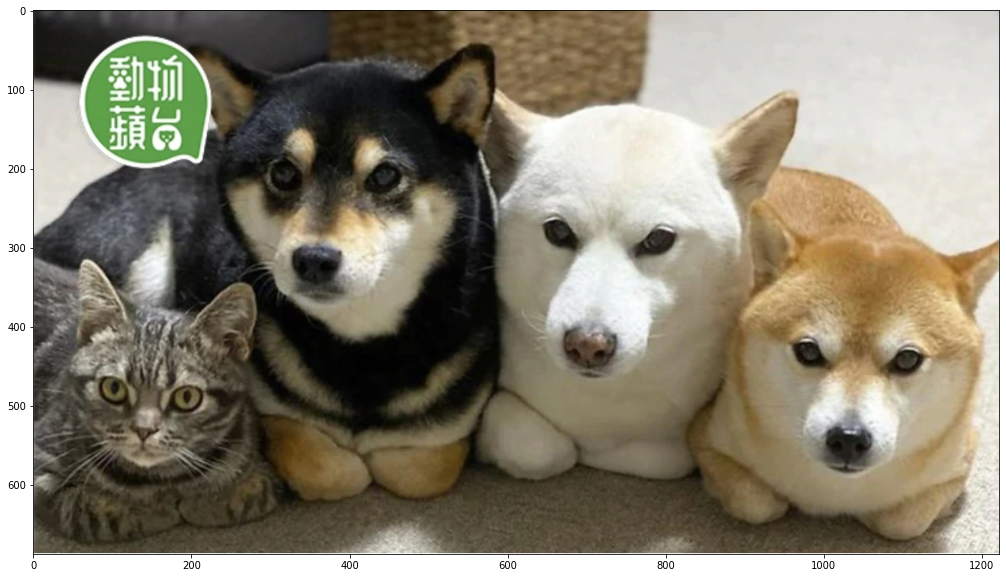

In [2]:
# 下載影像並且另存為input.jpg
# 如果判別其他影像，可以改成其他影像之連結，或者把上船隻影像，更改為input.jpg
#!wget下載圖片 input.jpg在指定資料夾當中
!wget https://hk.appledaily.com/resizer/4sYFs54l_cpbglyMvUkhgQcOYeg=/1223x688/filters:quality(100)/cloudfront-ap-northeast-1.images.arcpublishing.com/appledaily/Y2ELDLZO5RFTXPMZU4ZXUMDEOA.jpg -O input.jpg
im = cv2.imread("./input.jpg")
plt.figure(figsize=(20,10))
#cv2.imread讀檔
plt.imshow(im[:,:,::-1])

# 程式流程
* 宣告設定檔物件
* 取得設定檔，指定需要的模型種類
* 設定辨識值的門檻
* 下載模型
* 宣告偵測器，並且進行偵測
* 展示類別代碼及標記值
* 利用內建Visualizer將偵測出的圖形顯示出來

In [3]:
# Inference with a object detection model
# detectron2使用方式，必須讀取yaml格式的config設定檔，get_cfg()則是讀取一個預設的設定檔
# 按下來透過merge_from_file，把指定的設定檔(例如COCO-Detection/faster_rcnn_R_50_FPN_3.x.yaml)取代cfg
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md 列出detectron2目前
# MODEL.ROI_HEADS.SCORE_THRESH_TEST為模型的門檻值
# 利用遷移式學習的觀念，採用已經訓練好的權重進行影像推論，因此使用model_zoo.get_checkpoint_url
# 把設定好的設定檔cfg，傳入predictor，並進行im的預測
cfg = get_cfg()
#COCO-Detection設定檔 faster_rcnn速度最快的(預設的)
#set threshold for this model設定值
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")#設定類別、權重

# If your detectron2's version is not the most updated, please use direct link as followed, to get the link , please visit 
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

#predictor預測器
predictor = DefaultPredictor(cfg)
outputs = predictor(im)


model_final_280758.pkl: 167MB [00:06, 25.0MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [4]:
# 物件位置
# 列出預測出來的類別classes，以及預測出來的區塊boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([16, 16, 15, 16], device='cuda:0')
Boxes(tensor([[ 821.4992,  143.7769, 1219.3149,  671.0487],
        [ 154.9365,   38.4900,  635.8641,  629.1497],
        [   8.2872,  311.2283,  416.6817,  653.5689],
        [ 238.1167,   51.8546, 1066.2697,  635.1964]], device='cuda:0'))


In [5]:
# 全部的類別
# 從MetadataCatalog找出各個class的名稱
# 找出上面預測出來的classes所代表的名稱
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
preds

['dog', 'dog', 'cat', 'dog']

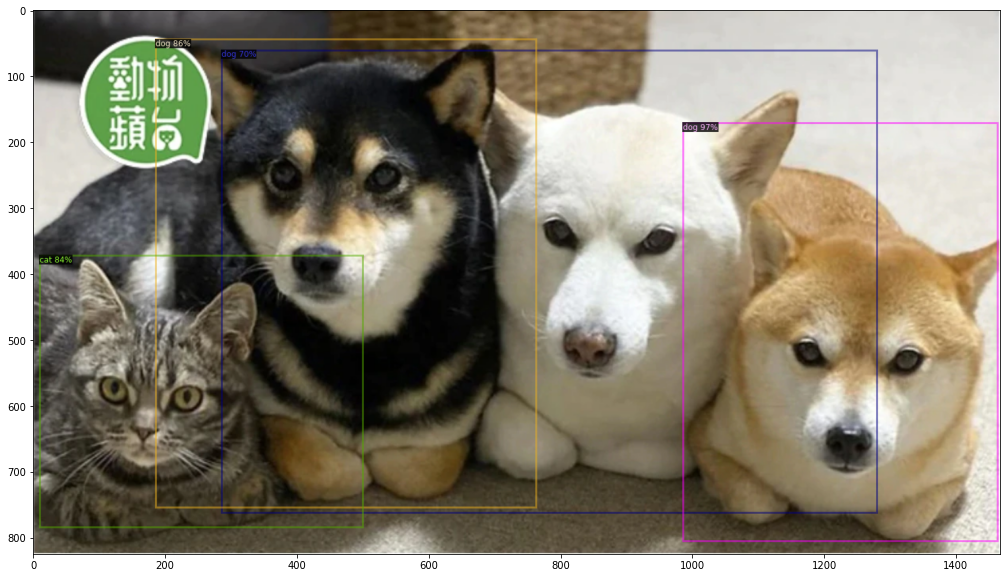

In [6]:
# Visualizer直接把預測畫方框畫出來 (方形)
# 把影像透過Visualizer畫出來，並且加上預測類別的機率
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_f10217.pkl: 178MB [00:06, 25.9MB/s]                           


['dog', 'dog', 'cat', 'dog']


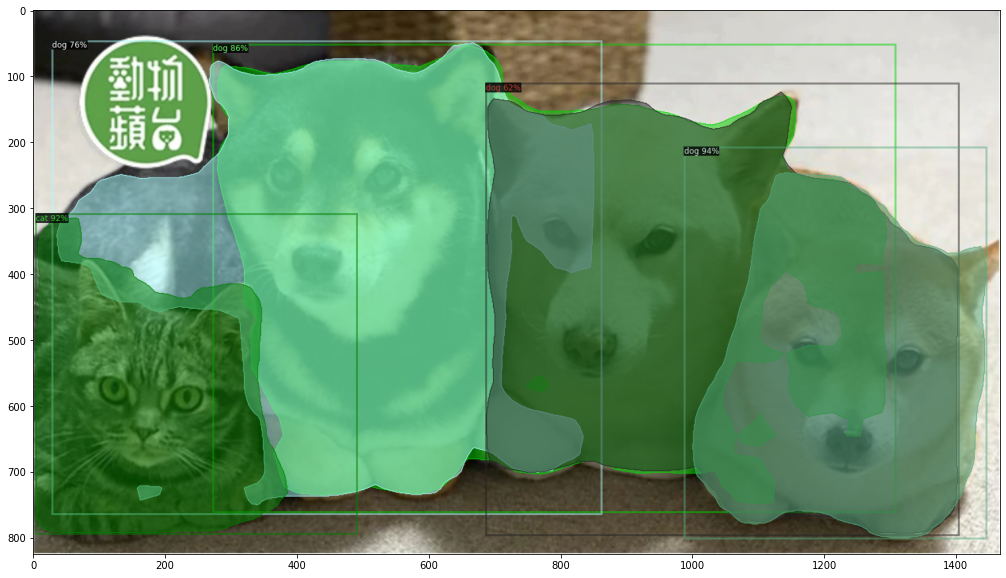

In [7]:
# mack_rcnn 區塊預測 (區塊) 與Visualizer唯一差別 = 設定檔不一樣
# 區塊預測程式，採用mask_rcnn_R_50_FPN_3.x.yaml設定檔
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = './model_final_f10217.pkl'
predictor = DefaultPredictor(cfg)
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
print(preds)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_a6e10b.pkl: 237MB [02:36, 1.52MB/s]                           


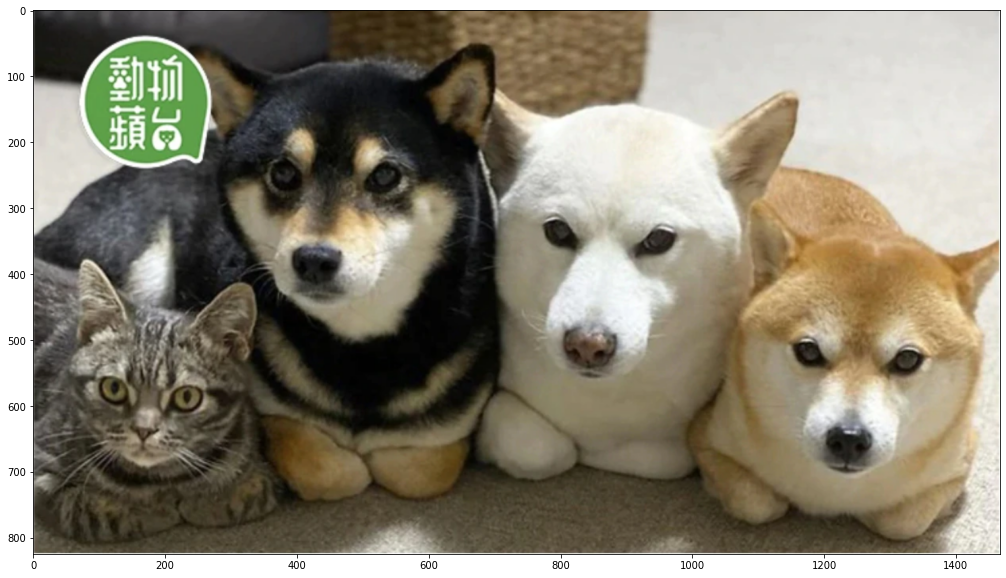

In [8]:
# Inference with a keypoint detection model
# panoptic全景預測 (圍出所有區塊)
# 預測圖形全景panoptic
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_cafdb1.pkl: 261MB [00:09, 26.5MB/s]                           


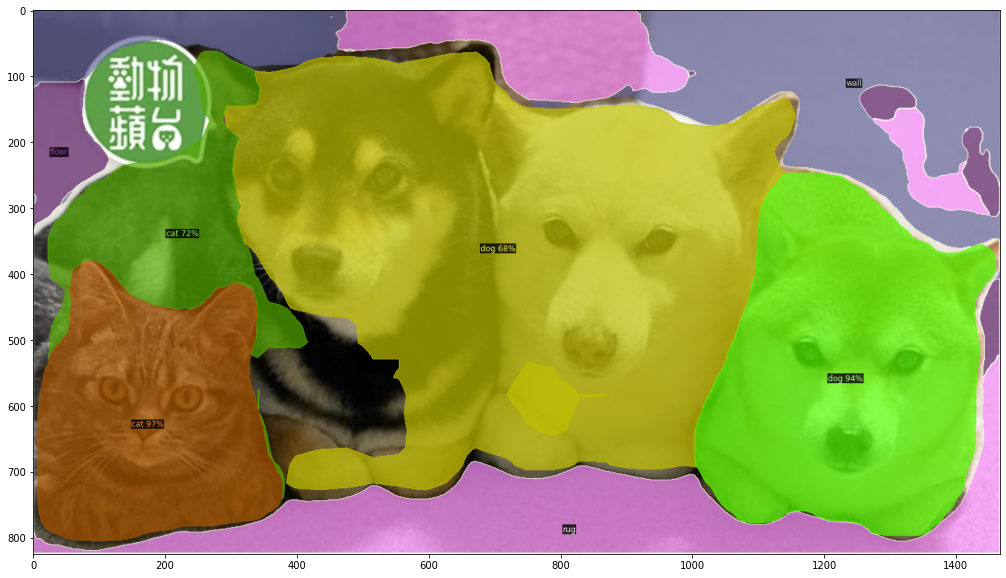

In [9]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())